- __차원의 저주__ : 데이터 학습을 위해 차원(변수의 개수)이 증가하면 학습데이터 수가 차원의 수보다 적어져 추정모델의 성능이 저하되는 현상
- 256X256 픽셀의 컬러이미지는 196,608개의 특성으로 변환 -> 사진 개수가 196,608개보다 작으면 모델의 성능 저하

- __차원축소__ : 모델의 성능을 높이기 위해 데이터에 담긴 일부 정보를 희생
- __특성 추출__ 을 통한 차원축소는 인간이 직관적으로 이해 불가. __특성 선택__ 은 해석가능

#### 1. 주성분을 사용해 특성 줄이기

사이킷런의 PCA를 사용하여 주성분 분석을 수행

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import datasets

digits = datasets.load_digits()

# 특성 행렬을 표준화 처리합니다.
features = StandardScaler().fit_transform(digits.data)

# 99%의 분산을 유지하도록 PCA 클래스 객체를 만듭니다.
pca = PCA(n_components = 0.99, whiten = True)

# PCA를 수행합니다.
features_pca = pca.fit_transform(features)

print('원본 특성의 개수:', features.shape[1])
print('줄어든 특성 개수:', features_pca.shape[1])

원본 특성의 개수: 64
줄어든 특성 개수: 54


![python image2](https://miro.medium.com/max/578/1*QALwLkPJG45E7_DsOccdaw.png)

__주성분분석(PCA)란?__  
1. 특성(변수)이 두개일때, 가장 분산이 큰 방향을 __첫번째 주성분__, 두번째로 분산이 큰 방향을 __두번째 주성분__ 이라 부름  
2. 이때 __첫번째 주성분__ 의 의미는 데이터를 가장 잘 설명할 수 있는 하나의 직선을 의미  
3. __두번째 주성분__ 은 첫번째 주성분과 직교하는 직선을 그으면 됨  
4. __PCA__ 는 다차원 공간의 모든 샘플을 주요한 몇가지 주성분에 투영시키는 것. -> 이 경우 몇가지 주성분의 정보는 희생 대신 __저차원의 데이터__ 를 얻을 수 있다!  

__알아둘점__  
1. 변수의 스케일의 차이 때문에 생기는 분산의 왜곡을 없애기 위해서 __표준화__ 필요!   
2. __가장 큰 고유값__ 의 고유벡터가 첫번째 주성분

__사이킷런의 pca 객체__
1. 매개변수 __n_components__
    - 1이상의 정수 전달 : 정수 만큼의 특성을 반환  
    - 0~1사이의 값 전달 : 원본 특성에서 그 값만큼의 분산을 유지한 최소한의 특성 개수 반환 -> 일반적으로 0.95 or 0.99 를 사용

2. 매개변수 __whiten__ : True로 지정하면 각 주성분의 값을 평균이0, 분산이 1이 되도록 변환
3. 매개변수 __solver__ : 'randomized'로 지정하면 아주 짧은 시간 안에 첫번째 주성분을 찾아주는 확률적 알고리즘 사용
4. 속성 __components___ : 주성분 확인
5. 속성 __explained_variance_ration___ : 주성분에 의해 설명된 분산 반환. n_components 값을 정하기 위해 유지되는 분산의 양이 크게 늘어나지 않는 지점을 찾을 때 활용 

__화이트닝(whiten)__ 이 적용되었기 때문에 두 특성의 스케일이 -3에서 4사이의 값으로 비슷하게 분포  
만약 화이트닝을 적용하지 않았다면 평균이0, 분산이 1인 분포가 나오지 않음 (여기서는 확실히 확인 불가능?)

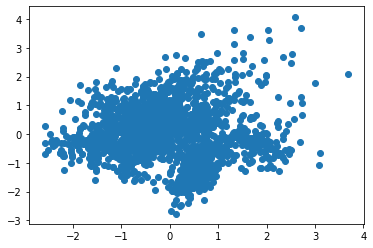

In [9]:
# 화이트닝 적용
import matplotlib.pyplot as plt
plt.scatter(features_pca[:, 0], features_pca[:, 1])
plt.show()

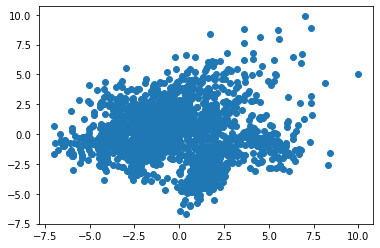

In [10]:
# 화이트닝을 적용하지 않음
pca_nowhiten = PCA(n_components = 0.99)
features_nowhiten = pca_nowhiten.fit_transform(features)
plt.scatter(features_nowhiten[:, 0], features_nowhiten[:, 1])
plt.show()

In [11]:
# 주성분 확인
pca_nowhiten.components_.shape

(54, 64)

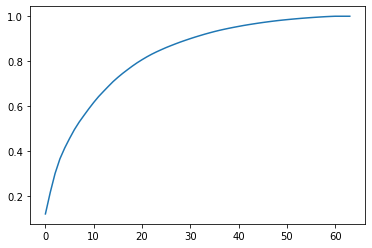

In [12]:
# 주성분에 의해 설명된 분산 시각화
import numpy as np

pca = PCA(whiten = True).fit(features)
plt.plot(np.cumsum(pca.explained_variance_ratio_))  # cumsum() : 누적합
plt.show()

__변경사항__
- 과거와 달리 사이킷런의 자유도 버그(샘플에서 1을 빼지 않던 버그)가 수정
- 그래서 사전에 표준화하지 않고 원본데이터를 PCA에 주입해야 올바른 결과를 얻을 수 있음

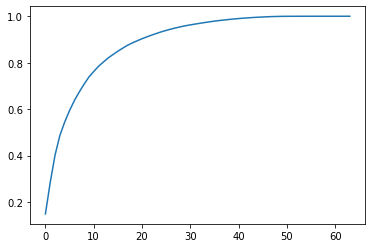

In [14]:
pca.fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [21]:
pca = PCA(n_components = 0.99, whiten=True)
features_pca = pca.fit_transform(digits.data)

print('원본 특성 개수', digits.data.shape[1])
print('줄어든 특성 개수', features_pca.shape[1])

원본 특성 개수 64
줄어든 특성 개수 41


#### 2. 선형적으로 구분되지 않은 데이터의 차원 축소하기

주성분 분석의 확장의 일부인 __커널 트릭__ 으로 비선형 차원 축소 수행

In [28]:
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_circles

# 선형적으로 구분되지 않는 데이터를 만듭니다.
features, _ = make_circles(n_samples = 1000, random_state = 1, noise = 0.1, factor = 0.1)

# 방사기저 합수(RBF, Radius Basis Function)를 사용하여 커널 PCA를 적용합니다.
kpca = KernelPCA(kernel = 'rbf', gamma=15, n_components=1)
features_kpca = kpca.fit_transform(features)

print('원본 특성 개수:', features.shape[1])
print('줄어든 특성 개수:', features_kpca.shape[1])

원본 특성 개수: 2
줄어든 특성 개수: 1


<img src="https://charleshsliao.files.wordpress.com/2017/06/screen-shot-2017-06-15-at-12-50-26-pm.png?w=1088" width="40%">

일반적인 데이터 셋과 달리 좌측 그림과 같은 데이터셋은 선형으로 차원 축소하면 __가장 중요한 정보(클래스) 가 손실__ 됨

__커널트릭(kernel trick)__ : 선형적으로 구분되지 않는 데이터를 선형적으로 구분되는 고차원으로 투영시키는 방법
- KernelPCA 에 사용되는 여러가지 커널 함수 : __가우시안 방사 기저 함수 커널(rbf)__ , 다항식 커널(poly), 시그모이드 커널(sigmoid), 선형 투영(linear)
- 일반 PCA보다 설정할 매개변수가 많고, 주성분의 개수를 비율로 지정 불가(n_components = 0.99 사용불가)
- 커널 트릭은 실제 고차원으로 데이터를 변환하지 않으면서 고차원 데이터를 다루는 듯 한 효과를 냄. 그래서 PCA처럼 주성분을 얻을 수는 없음

#### 3. 클래스 분리를 최대화하여 특성 줄이기

LDA(Linear Discriminant Analysis, 선형판별분석)를 사용하여 클래스를 최대한 분리하는 성분 축으로 특성을 투영  
* Latent Dirichlet allocation(LDA) 와 다름!

In [42]:
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()
features = iris.data
target = iris.target

# LDA 객체를 만들고 실행하여 특성을 변환
lda = LinearDiscriminantAnalysis(n_components=1)
features_lda = lda.fit(features, target).transform(features)

# 특성 개수를 출력합니다.
print('원본 특성 개수:', features.shape[1])
print('줄어든 특성 개수:', features_lda.shape[1])

원본 특성 개수: 4
줄어든 특성 개수: 1


In [44]:
# 각 성분이 설명하는 분산의 양을 확인합니다.
lda.explained_variance_ratio_

array([0.9912126])

<img src="https://search.pstatic.net/common/?src=http%3A%2F%2Fblogfiles.naver.net%2FMjAyMDA4MDVfMjc5%2FMDAxNTk2NTk1ODMxMTU0.TyXMJNRG_2QcdwMwCFUw6HMh2pqcL2J_XbxtPv3AIswg.86UrpNhFH32mpGKsw5D85qD8qoPPu8UVeIBsG3TEUOYg.PNG.mo223772%2Fimage.png&type=sc960_832" width="40%">

>__LDA(선형 판별 분석)__ : PCA가 가장 큰 분산의 축을 찾는 것을 주요 목표로 한다면, LDA는 거기에 더해 __클래스 간의 차이를 최대화__ 하는 목적을 가짐  
> - 만약 우측그림에서 주성분을 Y축으로 잡고 PCA를 수행하면 class(파란집단 / 초록집단)에 대한 정보 손실
> - 하지만 x축을 주성분으로 하면 분산의 크기라는 정보와 class에 대한 정보 두마리 토끼를 잡을 수 있다.
> - 사이킷런에서 LDA는 n_components 값을 None으로 지정하고 최적의 n_components를 구하는 함수를 정의 할 수 있다.

In [48]:
lda = LinearDiscriminantAnalysis(n_components = None)
features_lda = lda.fit(features, target)

# 설명된 분산의 비율이 담긴 배열을 저장합니다.
lda_var_ratios = lda.explained_variance_ratio_

# 함수를 만듭니다.
def select_n_components(var_ratio, goal_var: float) -> int:
    total_variance = 0     # 설명된 분산의 초기값을 지정하빈다.
    n_components = 0       # 특성 개수의 초기값을 지정합니다.
    
    # 각 특성의 설명된 분산을 순회합니다.
    for explained_variance in var_ratio:
        
        # 설명된 분산 값을 누적합니다.
        total_variance += explained_variance
        
        # 성분 개수를 카운트
        n_components += 1
        
        # 설명된 분산이 목표치에 도달하면 반복을 종료합니다.
        if total_variance >= goal_var:
            break
            
    # 성분 개수를 반환합니다.
    return n_components

# 함수를 실행합니다.
select_n_components(lda_var_ratios, 0.95)

1

#### 4. 행렬 분해를 사용하여 특성 줄이기

행렬의 모든 값이 양수일때는 Non-negative Matrix Factorization(비음수 행렬분해, NMF)을 사용하여 행렬의 차원을 축소

In [51]:
from sklearn.decomposition import NMF
from sklearn import datasets

digits = datasets.load_digits()
features = digits.data

# NMF를 만들고 학습하고 적용합니다.
nmf = NMF(n_components = 10, random_state=1)
features_nmf = nmf.fit_transform(features)

# 결과를 출력합니다.
print('원본 특성 개수:',features.shape[1])
print('줄어든 특성 개수:', features_nmf.shape[1])

원본 특성 개수: 64
줄어든 특성 개수: 10


__NMF의 시작점__
1. (NxM) 행렬은 (Nx1) 행렬과 (1xM) 행렬의 외적으로 구할 수 있음
2. 전자는 NxM 개의 원소, 후자는 N+M 개의 원소를 갖는다
3. 행렬 곱셉에서 곱하는 행렬은 결과행렬보다 훨씬 적은 차원을 가지고 있다.

__NMF란?__
- 특정 행렬에 대해서 곱해서 거의 원본행렬이 되는 여러개의 작은 행렬로 나누어 차원을 축소하는 방법
- 이론적으로는 특성 행렬 V(n x d) 는 W(n x r) 행렬과 H(r x d) 행렬의 외적으로 나타낼 수 있음. V = WH
- 단 특성행렬에 음수가 포함되면 안됨
- 만들어진 특성의 설명된 분산을 제공하지 않기 때문에 n__components의 최적값을 찾기 위해 여러번 시도해야 함

__NMF의 매개변수__
1. n_components : 작은 행렬로 나눌 때 r의 값을 지정
2. solver : 디폴트 값은 cd, 좌표하강법으로 NMF알고리즘 수행. 곱셈 업데이트 알고리즘 mu 옵션도 사용가능

In [62]:
# W 행렬은 features_nmf, H 행렬은 components_ 속성에 저장
print('W 행렬의 차원:', features_nmf.shape)
print('H 행렬의 차원:', nmf.components_.shape)
print('V 행렬의 차원:', features.shape)

W 행렬의 차원: (1797, 10)
H 행렬의 차원: (10, 64)
V 행렬의 차원: (1797, 64)


In [65]:
# 모든 행렬은 양수여야만 함
np.all(nmf.components_ >= 0)

True

In [69]:
# W, H 행렬의 점곱은 원본행렬 V와 매우 유사
np.mean(features - np.dot(features_nmf, nmf.components_))

-0.2006204374412849

In [70]:
# 곱셈 업데이트 알고리즘을 활용한 NMF

nmf_mu = NMF(n_components=10, solver = 'mu', random_state=1)
features_nmf_mu = nmf_mu.fit_transform(features)
np.mean(features - np.dot(features_nmf_mu, nmf_mu.components_))

-0.12629945585681077